# Joe Garcia
# Data 620 - Web Analytics
# Professor Alain Ledon
# 12/14/25
# Week Three - Assignment Graph Visualization



## Imports and Setup
Load the Python libraries needed for data loading, graph construction, analysis, and visualization.


In [16]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity


## Load SNAP KSC Time-Series Data (TXT to DataFrames)
Parse the SNAP KSC time-series format (two lines per record) into:
- `meta_df`: metadata for each item
- `df`: 128-length time-series vectors (one row per item)


In [20]:
data = pd.read_csv("MemePhr.txt", sep="\t")
df1 = data.T

data2 = pd.read_csv("TwtHtag.txt", sep = "\t")
df2 = data2.T

df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [36]:

def load_ksc_timeseries(path, max_items=None):
    metas = []
    series = []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    num_pairs = len(lines) // 2
    if max_items is not None:
        num_pairs = min(num_pairs, max_items)

    for i in range(num_pairs):
        meta_line = lines[2*i]
        ts_line = lines[2*i + 1]
        metas.append({"meta": meta_line})
        series.append([float(x) for x in ts_line.split()])

    meta_df = pd.DataFrame(metas)
    X_df = pd.DataFrame(series)
    return meta_df, X_df


## Verify Data Shapes and Preview
Confirm the datasets loaded as expected (e.g., 1000 rows × 128 time steps).


In [37]:
meta1, df1 = load_ksc_timeseries("MemePhr.txt", max_items=None)
meta2, df2 = load_ksc_timeseries("TwtHtag.txt", max_items=None)

print("df1 shape:", df1.shape)
print("df2 shape:", df2.shape)

print(meta2.head())
print(df2.head())


df1 shape: (1000, 128)
df2 shape: (1000, 128)
                                                meta
0  20340\t#fact\t2009-06-12 07:25:50\t1\t2009-08-...
1  35793\t#rememberwhen\t2009-06-12 19:08:32\t1\t...
2  9\t#shoutout\t2009-06-11 16:56:50\t1\t2009-08-...
3  1409\t#IranElection\t2009-06-11 17:25:54\t1\t2...
4  2215\t#whateverhappenedto\t2009-06-11 17:49:12...
          0           1           2           3           4          5    \
0    3.618053    3.334573    3.001863    3.073184    2.601639   2.447568   
1    0.610180    0.711913    0.831376    1.080789    1.268421   1.436960   
2    9.246655    7.257838    6.182470    5.330589    4.912716   5.120264   
3  157.013916  152.206421  138.145538  123.233765  105.869186  92.649178   
4    0.153306    0.182648    0.206072    0.267894    0.267894   0.206072   

         6          7          8          9    ...         118         119  \
0   2.531625   2.755680   2.789641   2.956232  ...  724.206543  686.237976   
1   1.488559   1.402107

## Construct Similarity Graph Using Cosine Similarity
Create a weighted undirected graph where nodes represent hashtags and edges represent similarity.


In [38]:
def build_similarity_graph_no_threshold(df, n=300, k=5):
    n = min(n, len(df))
    k = min(k, n - 1)

    X = df.iloc[:n].to_numpy()
    Xs = StandardScaler().fit_transform(X)
    S = cosine_similarity(Xs)

    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        idx = np.argsort(S[i])[::-1][1:k+1]
        for j in idx:
            G.add_edge(i, j, weight=float(S[i, j]))
    return G



## Build Graph Subset and Summary Statistics
Construct a 300-node similarity graph and inspect node/edge counts and connectivity.


In [39]:
G2 = build_similarity_graph_no_threshold(df2, n=300, k=5)

print("G2 nodes/edges:", G2.number_of_nodes(), G2.number_of_edges())
print("Connected components:", nx.number_connected_components(G2))


G2 nodes/edges: 300 1188
Connected components: 1


## Graph Metrics: Diameter, Clustering, and PageRank
Compute key graph metrics on the largest connected component.


In [40]:
largest_cc = max(nx.connected_components(G2), key=len)
H = G2.subgraph(largest_cc).copy()

diameter = nx.diameter(H)
avg_clustering = nx.average_clustering(H)
pagerank = nx.pagerank(H, weight="weight")

top10_pr = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

print("Largest CC nodes/edges:", H.number_of_nodes(), H.number_of_edges())
print("Diameter (largest CC):", diameter)
print("Average clustering (largest CC):", avg_clustering)
print("Top 10 PageRank nodes:", top10_pr)


Largest CC nodes/edges: 300 1188
Diameter (largest CC): 10
Average clustering (largest CC): 0.4151225718725719
Top 10 PageRank nodes: [(265, 0.005778932843521198), (247, 0.005743523744883986), (252, 0.005726708828945638), (277, 0.005632243099317484), (167, 0.00552292713068086), (5, 0.005459789247138906), (239, 0.005369385233568333), (292, 0.005328799519194522), (142, 0.0052721741339821215), (171, 0.005238019520700784)]


## Visualization: Force-Directed Layout of the Similarity Graph
Visualize the largest connected component using a spring layout.


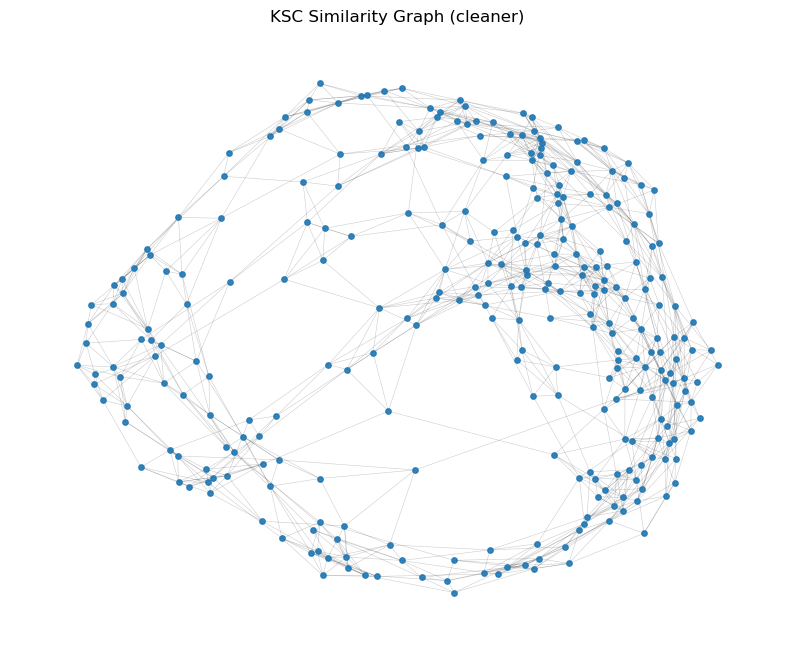

In [46]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, seed=42, k=0.25, iterations=200)

nx.draw_networkx_nodes(H, pos, node_size=15, alpha=0.9)
nx.draw_networkx_edges(H, pos, width=0.4, alpha=0.2) 

plt.title("KSC Similarity Graph (cleaner)")
plt.axis("off")
plt.show()


## Visualization: Strongest Connections Only
Filter to the top 15% of edge weights to highlight the most meaningful structure.


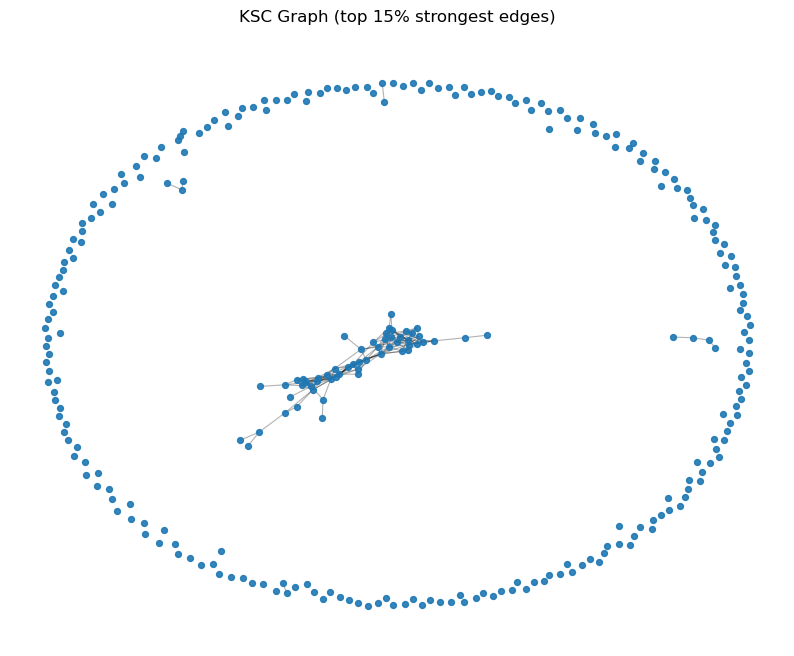

Edges before: 1188 after: 179


In [58]:

weights = np.array([d.get("weight", 1.0) for _, _, d in H.edges(data=True)])
cutoff = np.quantile(weights, 0.85)   
H_strong = nx.Graph((u, v, d) for u, v, d in H.edges(data=True) if d.get("weight", 1.0) >= cutoff)

H_strong.add_nodes_from(H.nodes())

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H_strong, seed=42, k=0.3, iterations=200)
nx.draw_networkx_nodes(H_strong, pos, node_size=18, alpha=0.9)
nx.draw_networkx_edges(H_strong, pos, width=0.8, alpha=0.3)

plt.title("KSC Graph (top 15% strongest edges)")
plt.axis("off")
plt.show()

print("Edges before:", H.number_of_edges(), "after:", H_strong.number_of_edges())



In [52]:
nodes_df = pd.DataFrame({"id": list(H.nodes())})
edges_df = pd.DataFrame(
    [(u, v, d.get("weight", 1.0)) for u, v, d in H.edges(data=True)],
    columns=["source", "target", "weight"]
)

nodes_df.to_csv("nodes.csv", index=False)
edges_df.to_csv("edges.csv", index=False)

print("Saved nodes.csv and edges.csv")


Saved nodes.csv and edges.csv


##  Visualization: Label Top PageRank Nodes
Highlight the most influential nodes using PageRank labels.


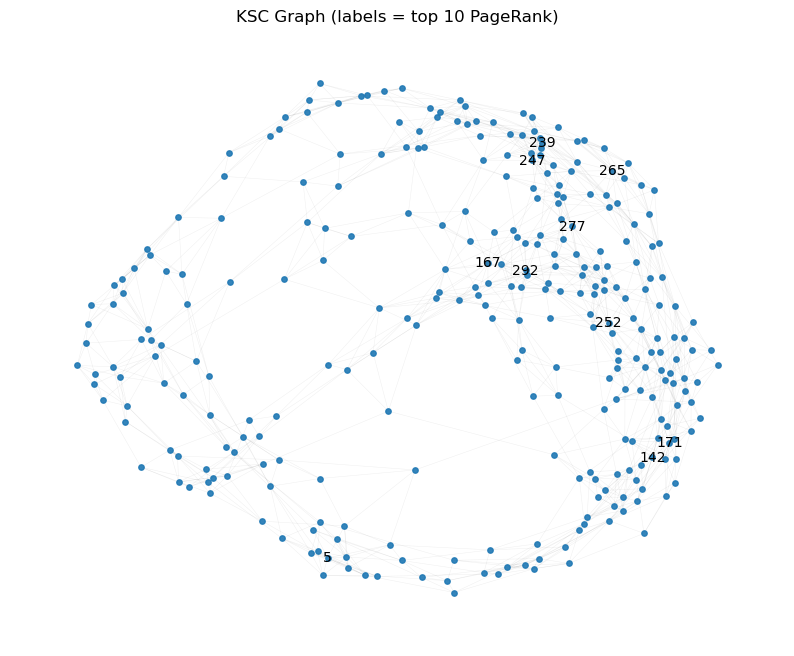

In [50]:
pr = nx.pagerank(H, weight="weight")
top_nodes = [n for n, _ in sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]]
labels = {n: str(n) for n in top_nodes}

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, seed=42, k=0.25, iterations=200)
nx.draw_networkx_nodes(H, pos, node_size=15, alpha=0.9)
nx.draw_networkx_edges(H, pos, width=0.4, alpha=0.06)
nx.draw_networkx_labels(H, pos, labels=labels, font_size=10)

plt.title("KSC Graph (labels = top 10 PageRank)")
plt.axis("off")
plt.show()


## Conclusion

In this assignment, I analyzed a subset of the SNAP KSC time-series dataset by transforming temporal activity patterns into a similarity-based graph. Each node represented a meme or Twitter hashtag, and edges were constructed using cosine similarity between time-series vectors, connecting each node to its most similar neighbors. To ensure computational efficiency and clarity in visualization, a 300-node subset of the data was used.

The resulting graph was fully connected, allowing meaningful structural analysis. The diameter of the largest connected component was found to be 10, indicating that even the most distant nodes in the network are connected through relatively short paths. Additionally, the average clustering coefficient of approximately 0.42 suggests a moderate level of local clustering, meaning that similar hashtags or phrases tend to form tightly connected groups. PageRank analysis further highlighted a small number of highly influential nodes that play a central role in the network structure.

Visualizations created using a force-directed layout and filtered to emphasize stronger connections revealed clear structural patterns and clusters within the network. Overall, this analysis demonstrates how time-series data can be effectively converted into a graph representation to uncover structural properties, influential nodes, and connectivity patterns that are not immediately visible from the raw data alone.
